# Materials & Methods

## Prepare environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!git clone "https://github.com/sunwucheng/IDB_drilling_signal.git" /content/drive/MyDrive/IDB_drilling_signal
!nvidia-smi

Mounted at /content/drive
fatal: destination path '/content/drive/MyDrive/IDB_drilling_signal' already exists and is not an empty directory.
/bin/bash: nvidia-smi: command not found


## Display signal data

### Load signal data

In [2]:
import numpy as np
import scipy.io as scio

def read_matFile(signal_path):
  signal_file = scio.loadmat(signal_path)
  signal_value = signal_file['samples']
  signal_value = np.squeeze(signal_value)
  return signal_value

def read_wavFile(signal_path):
  signal_rate, signal_value = scio.wavfile.read(signal_path)
  return signal_value, signal_rate

import librosa

def read_soundFile(signal_path):
  signal_value, signal_rate = librosa.load(signal_path, sr=None, mono=True, offset=0.0, duration=None)
  return signal_value, signal_rate

In [3]:
RATE = 8192
print("RATE: ", RATE, "Hz (default in Matlab)")

S32h = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment1/3-2h.mat")
S41h = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment1/4-1h.mat")
S42h = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment1/4-2h.mat")
S43b = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment1/4-3b.mat")
print("---------------------------------------")
print("S32h : ", S32h.shape, len(S32h)/RATE, 's')
print("S41h : ", S41h.shape, len(S41h)/RATE, 's')
print("S42h : ", S42h.shape, len(S42h)/RATE, 's')
print("S43b : ", S43b.shape, len(S43b)/RATE, 's')

RATE:  8192 Hz (default in Matlab)
---------------------------------------
S32h :  (8880128,) 1084.0 s
S41h :  (7216896,) 880.96875 s
S42h :  (11019776,) 1345.1875 s
S43b :  (22244352,) 2715.375 s


### Plot signal data

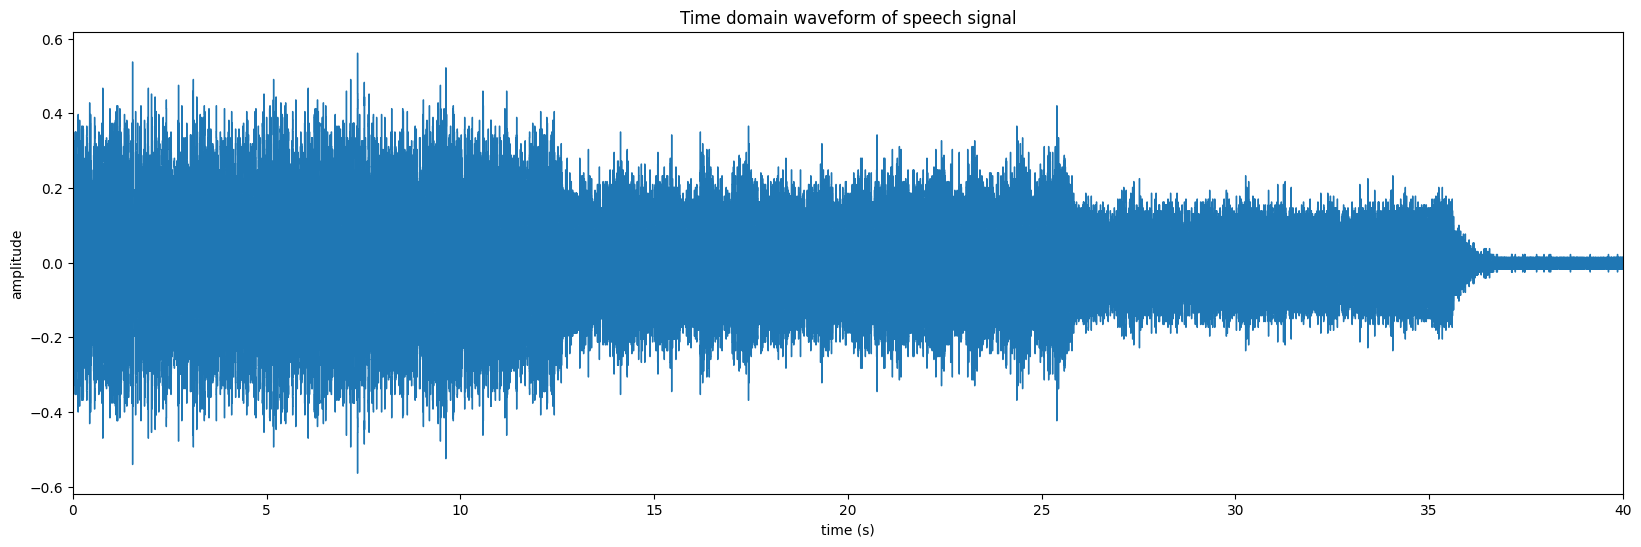

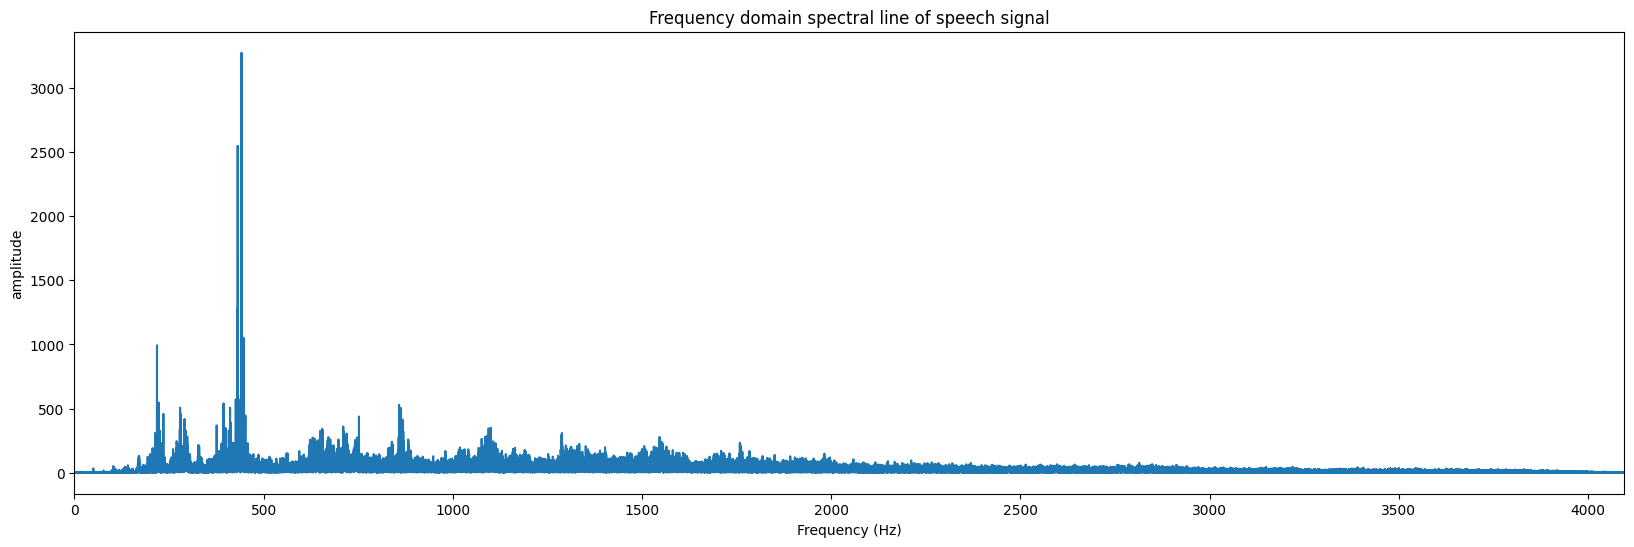

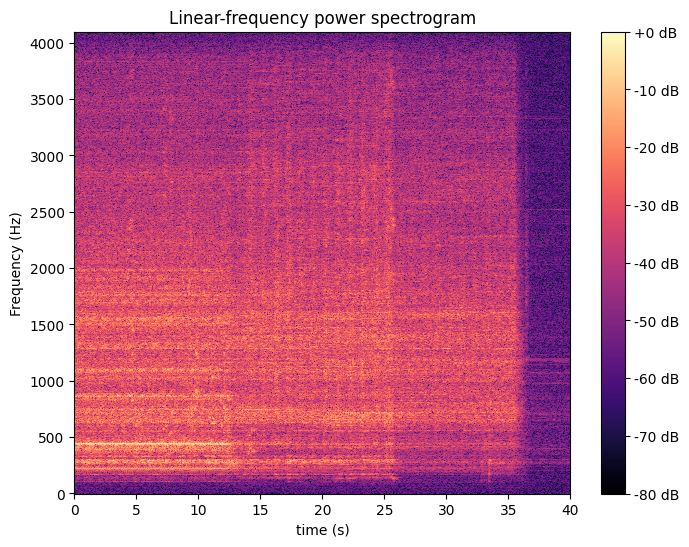

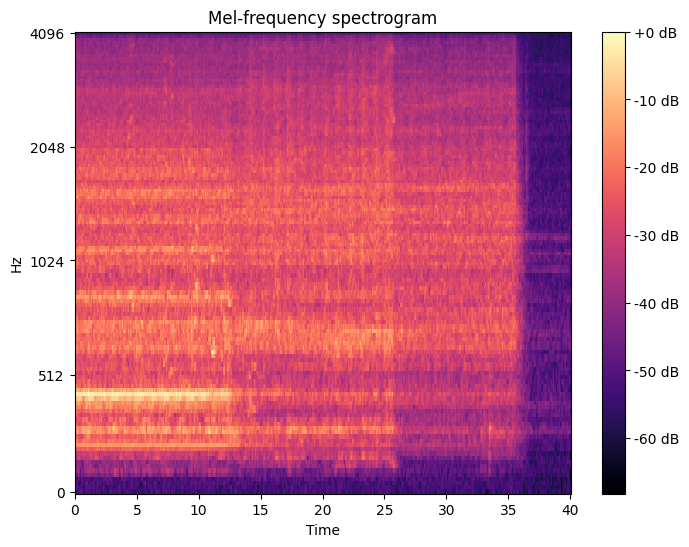

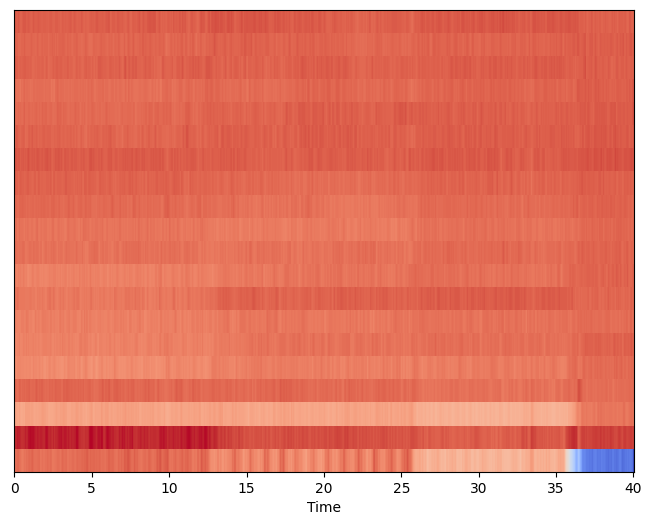

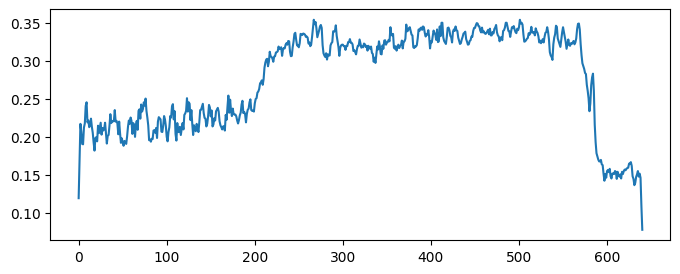

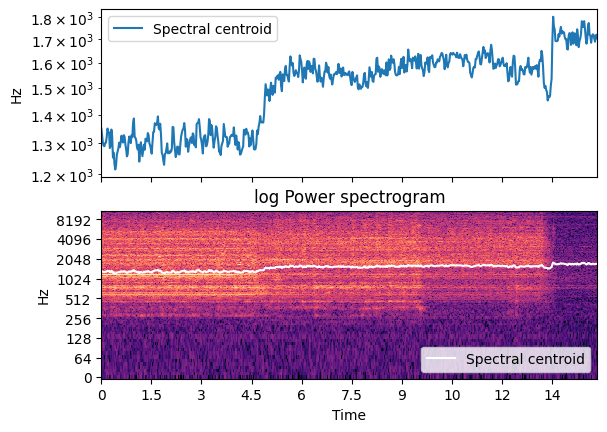

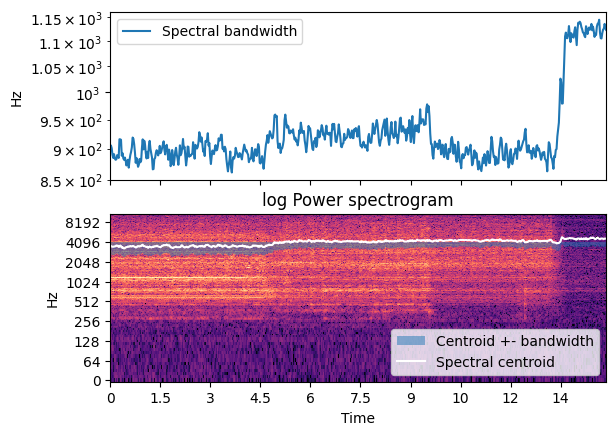

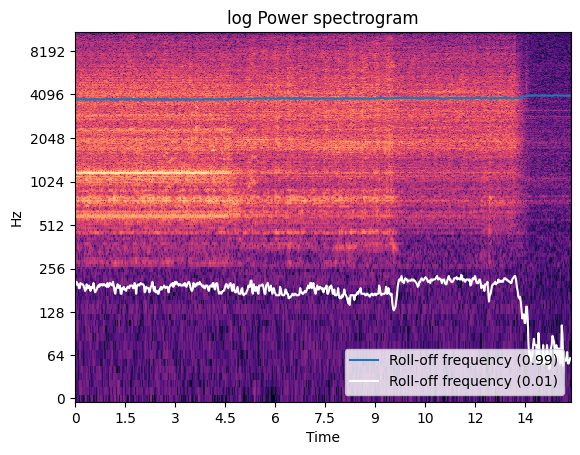

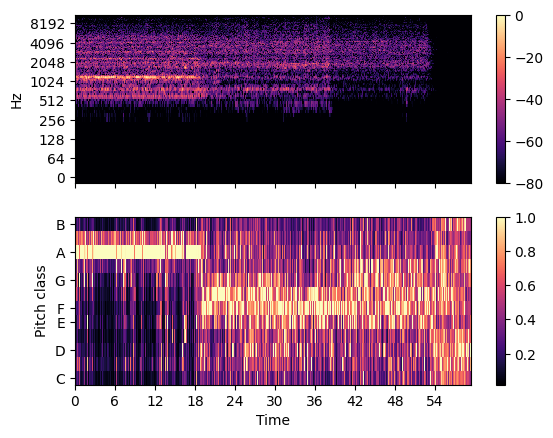

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

def displayWaveform(signal, rate):
  plt.figure(figsize=(20,6))
  max = np.max(np.absolute(signal))*1.2
  time = np.arange(0, len(SIGNAL)) / RATE
  # plt.plot(time, signal)
  librosa.display.waveshow(signal, sr=rate)
  plt.title("Time domain waveform of speech signal")
  plt.xlabel("time (s)")
  plt.ylabel("amplitude")
  plt.xlim(0,len(SIGNAL)/RATE)
  ymin, ymax = plt.ylim()
  ylim = np.maximum(np.abs(ymin), np.abs(ymax))
  plt.ylim(-ylim, ylim)

def displaySpectrum(signal, rate):
  plt.figure(figsize=(20,6)) 
  s = np.fft.fft(signal)
  m = np.abs(s)
  # f = np.linspace(0, rate, len(m))
  # plt.plot(f, m)
  n = len(signal)
  f = np.fft.fftfreq(n, 1/rate)
  plt.plot(f[:n//2],m[:n//2])
  plt.title("Frequency domain spectral line of speech signal")
  plt.xlabel("Frequency (Hz)")
  plt.ylabel("amplitude")
  plt.xlim(0, rate//2)

def displaySpectrogram(signal, rate, fftlen):    
  plt.figure(figsize=(8,6))
  # plt.specgram(signal, NFFT=fftlen, Fs=rate, noverlap=int(fftlen*0.25), window=np.hanning(fftlen))
  signal_db = librosa.amplitude_to_db(np.abs(librosa.stft(signal, hop_length=int(fftlen*0.25))), ref=np.max) 
  librosa.display.specshow(signal_db, sr=rate, hop_length=int(fftlen*0.25), x_axis='time', y_axis='linear')
  plt.title('Linear-frequency power spectrogram')
  plt.xlabel('time (s)')
  plt.ylabel('Frequency (Hz)')
  plt.colorbar(format="%+2.0f dB")

def displayMelspectrogram(signal, rate):
  plt.figure(figsize=(8,6))
  # melspectrogram = librosa.feature.melspectrogram(y=signal, sr=rate)
  D = np.abs(librosa.stft(signal))**2
  S = librosa.feature.melspectrogram(S=D, sr=rate)
  S_dB = librosa.power_to_db(S, ref=np.max)
  img = librosa.display.specshow(S_dB, sr=rate, fmax=rate/2, x_axis='time', y_axis='mel') 
  plt.title('Mel-frequency spectrogram')
  plt.colorbar(format='%+2.0f dB')

def diaplayMFCC(signal, rate):
  plt.figure(figsize=(8,6))
  mfccs = librosa.feature.mfcc(y=signal, sr=rate)
  librosa.display.specshow(mfccs, sr=rate, x_axis='time')

def displayZCR(signal, rate):
  plt.figure(figsize=(8,3))
  zcrs = librosa.feature.zero_crossing_rate(signal)  
  plt.plot(zcrs[0])

from sklearn import preprocessing
def normalize(x, axis=0):
    return preprocessing.minmax_scale(x, axis=axis)

def displayCentroids(signal, rate):
  # spectral_centroids = librosa.feature.spectral_centroid(y=signal, sr=rate)[0]
  # frames = range(len(spectral_centroids))
  # times = librosa.frames_to_time(frames)
  # librosa.display.waveshow(signal, sr=rate, alpha=0.4)
  # plt.plot(times, normalize(spectral_centroids), color='r')

  cent = librosa.feature.spectral_centroid(y=signal, sr=rate) 
  S, phase = librosa.magphase(librosa.stft(y=signal))
  S_db = librosa.amplitude_to_db(S, ref=np.max)
  librosa.feature.spectral_centroid(S=S)
  freqs, times, D = librosa.reassigned_spectrogram(signal, fill_nan=True)
  librosa.feature.spectral_centroid(S=np.abs(D), freq=freqs)
  times = librosa.times_like(cent)

  fig, ax = plt.subplots(nrows=2, sharex=True)
  ax[0].semilogy(times, cent[0], label='Spectral centroid')
  ax[0].set(ylabel='Hz', xticks=[], xlim=[times.min(), times.max()])
  ax[0].legend()
  ax[0].label_outer()

  librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax[1])
  ax[1].plot(times, cent.T, label='Spectral centroid', color='w')
  ax[1].set(title='log Power spectrogram')
  ax[1].legend(loc='lower right')

def displayBandwidth(signal, rate):
  # spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(y=signal+0.01, sr=rate)[0]
  # spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(y=signal+0.01, sr=rate, p=3)[0]
  # spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(y=signal+0.01, sr=rate, p=4)[0]
  # librosa.display.waveshow(signal, sr=rate, alpha=0.4)
  # normal2 = preprocessing.minmax_scale(spectral_bandwidth_2, axis=0)
  # normal3 = preprocessing.minmax_scale(spectral_bandwidth_3, axis=0)
  # normal4 = preprocessing.minmax_scale(spectral_bandwidth_4, axis=0)
  # spectral_centroids = librosa.feature.spectral_centroid(y=signal, sr=rate)[0]
  # frames = range(len(spectral_centroids))
  # times = librosa.frames_to_time(frames)
  # plt.plot(times, normal2, color='r')
  # plt.plot(times, normal3, color='g')
  # plt.plot(times, normal4, color='y')
  # plt.legend(('p = 2', 'p = 3', 'p = 4'))

  spec_bw = librosa.feature.spectral_bandwidth(y=signal, sr=rate)
  S, phase = librosa.magphase(librosa.stft(y=signal))
  S_db = librosa.amplitude_to_db(S, ref=np.max)
  librosa.feature.spectral_bandwidth(S=S)
  freqs, times, D = librosa.reassigned_spectrogram(signal, fill_nan=True)
  librosa.feature.spectral_bandwidth(S=np.abs(D), freq=freqs)
  times = librosa.times_like(spec_bw)
  centroid = librosa.feature.spectral_centroid(S=S)

  fig, ax = plt.subplots(nrows=2, sharex=True)
  ax[0].semilogy(times, spec_bw[0], label='Spectral bandwidth')
  ax[0].set(ylabel='Hz', xticks=[], xlim=[times.min(), times.max()])
  ax[0].legend()
  ax[0].label_outer()

  librosa.display.specshow(S_db, y_axis='log', x_axis='time', ax=ax[1])
  ax[1].set(title='log Power spectrogram')
  ax[1].fill_between(times, np.maximum(0, centroid[0] - spec_bw[0]), np.minimum(centroid[0] + spec_bw[0], rate/2), alpha=0.5, label='Centroid +- bandwidth')
  ax[1].plot(times, centroid[0], label='Spectral centroid', color='w')
  ax[1].legend(loc='lower right')

def displayRolloff(signal, rate):
  # spectral_rolloff = librosa.feature.spectral_rolloff(y=signal+0.01, sr=rate)[0]
  # librosa.display.waveshow(signal, sr=rate, alpha=0.4)
  # spectral_centroids = librosa.feature.spectral_centroid(y=signal, sr=rate)[0]
  # frames = range(len(spectral_centroids))
  # times = librosa.frames_to_time(frames)
  # normals = preprocessing.minmax_scale(spectral_rolloff, axis=0)
  # plt.plot(times, normals, color='r')

  librosa.feature.spectral_rolloff(y=signal, sr=rate)
  rolloff = librosa.feature.spectral_rolloff(y=signal, sr=rate, roll_percent=0.99)
  rolloff_min = librosa.feature.spectral_rolloff(y=signal, sr=rate, roll_percent=0.01)
  S, phase = librosa.magphase(librosa.stft(signal))
  S_db = librosa.amplitude_to_db(S, ref=np.max)
  librosa.feature.spectral_rolloff(S=S, sr=rate)
  librosa.feature.spectral_rolloff(y=signal, sr=rate, roll_percent=0.95)

  fig, ax = plt.subplots()
  librosa.display.specshow(S_db, y_axis='log', x_axis='time', ax=ax)
  ax.plot(librosa.times_like(rolloff), rolloff[0], label='Roll-off frequency (0.99)')
  ax.plot(librosa.times_like(rolloff), rolloff_min[0], color='w', label='Roll-off frequency (0.01)')
  ax.legend(loc='lower right')
  ax.set(title='log Power spectrogram')

def displayChromastft(signal, rate, fftlen):
  # chromagram = librosa.feature.chroma_stft(signal, sr=rate, hop_length=int(fftlen*0.25))
  # librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=fftlen*0.25, cmap='coolwarm')

  S = np.abs(librosa.stft(signal))
  chroma = librosa.feature.chroma_stft(S=S, sr=rate)
  S = np.abs(librosa.stft(signal, n_fft=fftlen))**2
  S_db = librosa.amplitude_to_db(S, ref=np.max)
  chroma = librosa.feature.chroma_stft(S=S, sr=rate)

  fig, ax = plt.subplots(nrows=2, sharex=True)
  img = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax[0])
  fig.colorbar(img, ax=[ax[0]])
  ax[0].label_outer()
  img = librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', ax=ax[1])
  fig.colorbar(img, ax=[ax[1]])

def displayChromacqt(signal, rate, n_chroma, n_fft):
  chroma_stft = librosa.feature.chroma_stft(y=signal, sr=rate, n_chroma=n_chroma, n_fft=n_fft)
  chroma_cq = librosa.feature.chroma_cqt(y=signal, sr=rate)

  fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
  img1 = librosa.display.specshow(chroma_stft, x_axis='time', y_axis='chroma', ax=ax[0])
  ax[0].set(title='chroma_stft')
  ax[0].label_outer()

  img2 = librosa.display.specshow(chroma_cq, x_axis='time', y_axis='chroma', ax=ax[1])
  ax[1].set(title='chroma_cqt')
  fig.colorbar(img2, ax=ax)

def displayChromacens(signal, rate):
  chroma_cens = librosa.feature.chroma_cens(y=signal, sr=rate)
  chroma_cq = librosa.feature.chroma_cqt(y=signal, sr=rate)

  fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
  img1 = librosa.display.specshow(chroma_cq, x_axis='time', y_axis='chroma', ax=ax[0])
  ax[0].set(title='chroma_cq')
  ax[0].label_outer()
  img2 = librosa.display.specshow(chroma_cens, x_axis='time', y_axis='chroma', ax=ax[1])
  ax[1].set(title='chroma_cens')
  fig.colorbar(img1, ax=ax)

def displayChromavqt(signal, rate, n_bins):
  chroma_cq = librosa.feature.chroma_cqt(y=signal, sr=rate, n_chroma=n_bins)
  chroma_vq = librosa.feature.chroma_vqt(y=signal, sr=rate, intervals='ji5', bins_per_octave=n_bins)

  fig, ax = plt.subplots(nrows=2, sharex=True)
  img1 = librosa.display.specshow(chroma_cq, x_axis='time', y_axis='chroma', ax=ax[0], bins_per_octave=n_bins)
  ax[0].set(ylabel='chroma_cqt')
  ax[0].label_outer()

  img2 = librosa.display.specshow(chroma_vq, y_axis='chroma_fjs', x_axis='time', ax=ax[1], bins_per_octave=n_bins, intervals='ji5')
  ax[1].set(ylabel='chroma_vqt')
  fig.colorbar(img2, ax=ax)

def plot_wave(signal, rate):  
  displayWaveform(signal, rate)
  displaySpectrum(signal, rate)
  displaySpectrogram(signal, rate, fftlen=512)
  displayMelspectrogram(signal, rate)
  diaplayMFCC(signal, rate)
  displayZCR(signal, rate)
  displayCentroids(signal, rate)
  displayBandwidth(signal, rate)
  displayRolloff(signal, rate)
  displayChromastft(signal, rate, fftlen=512)
  # displayChromacqt(signal, rate, n_chroma=12, n_fft=512)
  # displayChromacens(signal, rate)
  # displayChromavqt(signal, rate, n_bins=24)

SIGNAL = S32h[-40*RATE:]
plot_wave(SIGNAL, RATE)

import IPython

IPython.display.Audio(data=SIGNAL, rate=RATE)

# Classification model

### Data pre-treatment

| signal| mat2wav | pick |
| :---: | :---: | :---: |
| S32h | 00:00-17:36 | 02:00-12:00 |
| S41h | 01:21-14:03 | 02:00-12:00 |
| S42h | 00:00-21:24 | 02:00-12:00 |
| S43b | 01:01-37:31 | 02:00-12:00 14:00-24:00 26:00-36:00 |

In [ ]:
def cut_signal(signal_series):

  sample_size = int(RATE/2)         # 4096
  sample_step = int(sample_size/4)  # 512
  sample_data = []

  for i in range((len(signal_series)-sample_size) // sample_step):
    sample_data.append(signal_series[i*sample_step : (i*sample_step+sample_size)])

  sample_data = np.stack(sample_data)
  sample_data = np.squeeze(sample_data)

  # np.random.seed(42)
  # np.random.shuffle(sample_data)
  
  return sample_data

S32hCX = cut_signal(S32h[120*RATE:720*RATE])
S41hCX = cut_signal(S41h[120*RATE:720*RATE])
S42hCX = cut_signal(S42h[120*RATE:720*RATE])
S43bCX1 = cut_signal(S43b[120*RATE:720*RATE])
S43bCX2 = cut_signal(S43b[840*RATE:1440*RATE])
S43bCX3 = cut_signal(S43b[1560*RATE:2160*RATE])

print(S32hCX.shape)
print(S41hCX.shape)
print(S42hCX.shape)
print(S43bCX1.shape)
print(S43bCX2.shape)
print(S43bCX3.shape)

S32hCY = np.repeat(0, len(S32hCX))
S41hCY = np.repeat(0, len(S41hCX))
S42hCY = np.repeat(0, len(S42hCX))
S43bCY1 = np.repeat(1, len(S43bCX1))
S43bCY2 = np.repeat(1, len(S43bCX2))
S43bCY3 = np.repeat(1, len(S43bCX3))

print(S32hCY.shape)
print(S41hCY.shape)
print(S42hCY.shape)
print(S43bCY1.shape)
print(S43bCY2.shape)
print(S43bCY3.shape)

In [ ]:
X_set = np.concatenate((S32hCX, S41hCX, S42hCX, S43bCX1, S43bCX2, S43bCX3), axis=0)
print(X_set.shape)
X_set = X_set.reshape((X_set.shape[0], X_set.shape[1], 1))
print(X_set.shape)
print(X_set[0])

Y_set = np.concatenate((S32hCY, S41hCY, S42hCY, S43bCY1, S43bCY2, S43bCY3), axis=0)
num_classes = len(np.unique(Y_set))
print(Y_set.shape)
print(Y_set)

from keras.utils.np_utils import to_categorical

Y_set = to_categorical(Y_set, num_classes=num_classes)
print(Y_set.shape)
print(Y_set)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_set, Y_set, test_size=0.33, random_state=42)
print(x_train.shape)
print(x_train[0])
print(x_test.shape)
print(x_test[0])
print(y_train.shape)
print(y_train)
print(y_test.shape)
print(y_test)

In [ ]:
import gc

del S32hCX, S41hCX, S42hCX, S43bCX1, S43bCX2, S43bCX3, S32hCY, S41hCY, S42hCY, S43bCY1, S43bCY2, S43bCY3, X_set, Y_set
gc.collect()

In [ ]:
from tensorflow import keras

## 1D mix Conv model

In [ ]:
def make_model():

  input_layer = keras.Input(shape=(x_train.shape[1:]))
  x = keras.layers.Conv1D(filters=32, kernel_size=9, strides=2, activation="relu", padding="same")(input_layer)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv1D(filters=64, kernel_size=9, strides=2, activation="relu", padding="same")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv1D(filters=128, kernel_size=6, strides=2, activation="relu", padding="same")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv1D(filters=256, kernel_size=6, strides=2, activation="relu", padding="same")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv1D(filters=512, kernel_size=3, strides=2, activation="relu", padding="same")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv1D(filters=1024, kernel_size=3, strides=2, activation="relu", padding="same")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(4096, activation="relu")(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.Dense(4096, activation="relu", kernel_regularizer=keras.regularizers.L2())(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.Dense(1024, activation="relu", kernel_regularizer=keras.regularizers.L2())(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.L2())(x)
  output_layer = keras.layers.Dense(num_classes, activation="softmax")(x)

  return keras.Model(inputs=input_layer, outputs=output_layer)

model = make_model()
model.summary()
keras.utils.plot_model(model, show_shapes=True)

## Compile&Training

In [ ]:
model.compile(optimizer='sgd', 
              loss='binary_crossentropy',
              metrics=['accuracy',
                       keras.metrics.AUC(),
                       keras.metrics.Precision(),
                       keras.metrics.Recall()])

callbacks = [
            #  keras.callbacks.ModelCheckpoint("best_model.h5",
            #                                  monitor="loss",
            #                                  mode="min",
            #                                  save_best_only=True),
             keras.callbacks.EarlyStopping(monitor="val_loss",
                                           mode="min",
                                           patience=10,
                                           restore_best_weights=True),
             keras.callbacks.ReduceLROnPlateau(monitor="val_loss", 
                                               factor=0.2, 
                                               patience=2,
                                               min_lr=0.000001),
            #  keras.callbacks.TensorBoard(log_dir="/content/drive/MyDrive/IDB_drilling_signal/outputs/logs",
            #                              histogram_freq=1,
            #                              write_graph=True, 
            #                              write_images=True)
            ]

history = model.fit(x_train, y_train,
                    validation_split=0.2, 
                    epochs=300, 
                    batch_size=64, 
                    callbacks=callbacks, 
                    shuffle=True)

model.save("/content/drive/MyDrive/IDB_drilling_signal/outputs/model.h5")
np.save("/content/drive/MyDrive/IDB_drilling_signal/outputs/history.npy", history.history, allow_pickle=True)
hist = np.load("/content/drive/MyDrive/IDB_drilling_signal/outputs/history.npy", allow_pickle=True)

## Plot history metrics

In [ ]:
def plot_history_metrics(history):
  
  total_plots = len(history)
  cols = total_plots // 2
  rows = total_plots // cols

  if total_plots % cols != 0:
    rows += 1

  pos = range(1, total_plots + 1)

  plt.figure(figsize=(15, 10))
  for i, (key, value) in enumerate(history.items()):
    plt.subplot(rows, cols, pos[i])
    plt.plot(range(len(value)), value)
    plt.title(str(key))

plot_history_metrics(history.history)

# %load_ext tensorboard
# %tensorboard --logdir "/content/drive/MyDrive/IDB_drilling_signal/output/logs"

## Test-set evaluation

In [ ]:
test_loss, test_accuracy, test_auc, test_precision, tes_recall = model.evaluate(x_test, y_test)
print("Test loss", test_loss)
print("Test accuracy", test_accuracy)
print("test_auc", test_auc) 
print("test_precision", test_precision) 
print("tesrecall", tes_recall)

# Regression model

## Data pre-processment

| signal| Table | mat2wav |
| :---: | :---: | :---: |
| S32h | 15:25:43-15:43:19 | 00:00-17:36 |
| S41h | 16:26:25-16:39:34 | 00:54-14:03 |
| S42h | 16:55:23-17:16:31 | 00:00-21:08 |
| S43b | 17:24:00-18:00:25 | 01:05-37:30 |

In [59]:
S32hRX = S32h[0:1056*RATE]
S41hRX = S41h[54*RATE:843*RATE]
S42hRX = S42h[0:1268*RATE]
S43bRX = S43b[65*RATE:2250*RATE]

In [60]:
import pandas as pd

def load_table(table_path, time_start, time_end):
  SIGNAL_pd = pd.read_excel(table_path)
  IPython.display.display(SIGNAL_pd)
  SIGNAL_arr = SIGNAL_pd.values[time_start : time_end,1:-1]
  print(type(SIGNAL_arr), SIGNAL_arr.shape, len(SIGNAL_arr)-1, "s")
  print(SIGNAL_arr)
  return SIGNAL_arr

In [61]:
S32hRY = load_table("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment1/3-2h.xls", 46, 1103)
S41hRY = load_table("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment1/4-1h.xls", 28, 818)
S42hRY = load_table("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment1/4-2h.xls", 56, 1325)
S43bRY = load_table("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment1/4-3b.xls", 3, 2189)

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


,0,1,2,3,4,5,6,7
0,钻进数据表,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,报表日期:,22/11/06,NaN,18:10:03,NaN,NaN,NaN,NaN
2,日期,时间,回转速度,扭矩,水泵流量,钻进速度,钻压,NaN
3,22/11/06,15:25:00,308.00,0.00,5.00,0.00,0.00,NaN
4,22/11/06,15:25:01,308.00,0.00,5.00,0.00,0.00,NaN
...,...,...,...,...,...,...,...,...
1101,22/11/06,15:43:18,309.00,13.00,5.00,0.00,786.00,NaN
1102,22/11/06,15:43:19,312.00,0.00,5.00,0.00,0.00,NaN
1103,22/11/06,15:43:20,314.00,0.00,5.00,0.00,0.00,NaN
1104,22/11/06,15:43:21,313.00,0.00,5.00,-600.00,0.00,NaN


<class 'numpy.ndarray'> (1057, 6) 1056 s
[['15:25:43' '307.00' '0.00' '5.00' '0.00' '204.00']
 ['15:25:44' '308.00' '0.00' '5.00' '0.00' '147.00']
 ['15:25:45' '308.00' '0.00' '5.00' '0.00' '220.00']
 ...
 ['15:43:17' '308.00' '20.00' '5.00' '0.00' '918.00']
 ['15:43:18' '309.00' '13.00' '5.00' '0.00' '786.00']
 ['15:43:19' '312.00' '0.00' '5.00' '0.00' '0.00']]
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


,0,1,2,3,4,5,6,7
0,钻进数据表,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,报表日期:,22/11/06,NaN,18:12:08,NaN,NaN,NaN,NaN
2,日期,时间,回转速度,扭矩,水泵流量,钻进速度,钻压,NaN
3,22/11/06,16:26:00,261.00,0.00,7.00,0.00,0.00,NaN
4,22/11/06,16:26:01,261.00,0.00,7.00,0.00,0.00,NaN
...,...,...,...,...,...,...,...,...
829,22/11/06,16:39:46,303.00,0.00,5.00,0.00,0.00,NaN
830,22/11/06,16:39:47,303.00,0.00,5.00,0.00,0.00,NaN
831,22/11/06,16:39:48,303.00,0.00,5.00,0.00,0.00,NaN
832,22/11/06,16:39:49,303.00,0.00,5.00,0.00,0.00,NaN


<class 'numpy.ndarray'> (790, 6) 789 s
[['16:26:25' '261.00' '0.00' '7.00' '0.00' '0.00']
 ['16:26:26' '260.00' '0.00' '7.00' '0.00' '2.00']
 ['16:26:27' '260.00' '0.00' '7.00' '0.00' '14.00']
 ...
 ['16:39:32' '298.00' '45.00' '5.00' '60.00' '638.00']
 ['16:39:33' '298.00' '45.00' '5.00' '60.00' '638.00']
 ['16:39:34' '307.00' '0.00' '5.00' '0.00' '0.00']]
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


,0,1,2,3,4,5,6,7
0,钻进数据表,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,报表日期:,22/11/06,NaN,18:13:17,NaN,NaN,NaN,NaN
2,日期,时间,回转速度,扭矩,水泵流量,钻进速度,钻压,NaN
3,22/11/06,16:54:30,302.00,0.00,6.00,60.00,0.00,NaN
4,22/11/06,16:54:31,302.00,0.00,6.00,0.00,0.00,NaN
...,...,...,...,...,...,...,...,...
1339,22/11/06,17:16:46,303.00,28.00,5.00,0.00,0.00,NaN
1340,22/11/06,17:16:47,304.00,16.00,5.00,-420.00,0.00,NaN
1341,22/11/06,17:16:48,308.00,3.00,5.00,-1380.00,0.00,NaN
1342,22/11/06,17:16:49,309.00,0.00,5.00,-1380.00,0.00,NaN


<class 'numpy.ndarray'> (1269, 6) 1268 s
[['16:55:23' '302.00' '0.00' '5.00' '0.00' '173.00']
 ['16:55:24' '302.00' '0.00' '5.00' '0.00' '176.00']
 ['16:55:25' '302.00' '0.00' '5.00' '0.00' '173.00']
 ...
 ['17:16:29' '300.00' '50.00' '5.00' '60.00' '1322.00']
 ['17:16:30' '297.00' '53.00' '5.00' '0.00' '1246.00']
 ['17:16:31' '295.00' '47.00' '5.00' '60.00' '0.00']]
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


,0,1,2,3,4,5,6,7
0,钻进数据表,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,报表日期:,22/11/06,NaN,18:14:05,NaN,NaN,NaN,NaN
2,日期,时间,回转速度,扭矩,水泵流量,钻进速度,钻压,NaN
3,22/11/06,17:24:00,302.00,0.00,5.00,0.00,0.00,NaN
4,22/11/06,17:24:01,302.00,0.00,5.00,0.00,14.00,NaN
...,...,...,...,...,...,...,...,...
2209,22/11/06,18:00:46,0.00,0.00,0.00,0.00,0.00,NaN
2210,22/11/06,18:00:47,0.00,0.00,0.00,0.00,0.00,NaN
2211,22/11/06,18:00:48,0.00,0.00,0.00,0.00,0.00,NaN
2212,22/11/06,18:00:49,0.00,0.00,0.00,0.00,0.00,NaN


<class 'numpy.ndarray'> (2186, 6) 2185 s
[['17:24:00' '302.00' '0.00' '5.00' '0.00' '0.00']
 ['17:24:01' '302.00' '0.00' '5.00' '0.00' '14.00']
 ['17:24:02' '302.00' '0.00' '5.00' '0.00' '37.00']
 ...
 ['18:00:23' '325.00' '12.00' '5.00' '0.00' '1081.00']
 ['18:00:24' '325.00' '12.00' '5.00' '0.00' '1061.00']
 ['18:00:25' '327.00' '0.00' '5.00' '0.00' '0.00']]


In [62]:
def enlarge_value(array, length):
  L = array.shape[0]
  W = array.shape[1]
  new_section = np.zeros([(L-1)*length, W-1])
  for i in range(L - 1):   
    new_second = np.zeros([length, W-1])
    for j in range(W - 1):
      start_value = float(array[i, j+1])
      end_value = float(array[i+1, j+1])
      new_second[:,j] = np.linspace(start_value, end_value, length + 2)[1:-1]  
    new_section[i*length:(i+1)*length,:] = new_second
  return new_section

In [63]:
S32hRY = enlarge_value(S32hRY, RATE)
S41hRY = enlarge_value(S41hRY, RATE)
S42hRY = enlarge_value(S42hRY, RATE)
S43bRY = enlarge_value(S43bRY, RATE)

In [64]:
def pick_value(signal, label):

  sample_size = int(RATE/2)         # 4096
  sample_step = int(sample_size/4)  # 512
  sample_data = []
  sample_idx = []

  for i in range((len(signal)-sample_size) // sample_step):
    sample_data.append(signal[i*sample_step : (i*sample_step+sample_size)])
    sample_idx.append(i*sample_step + sample_size//2)

  sample_data = np.stack(sample_data)
  sample_data = np.squeeze(sample_data)
  sample_label = label[sample_idx]
  
  return sample_data, sample_label

In [65]:
S32hRX, S32hRY = pick_value(S32hRX, S32hRY)
S41hRX, S41hRY = pick_value(S41hRX, S41hRY)
S42hRX, S42hRY = pick_value(S42hRX, S42hRY)
S43bRX, S43bRY = pick_value(S43bRX, S43bRY)

In [66]:
print(S32hRX.shape, S32hRY.shape)
print(S41hRX.shape, S41hRY.shape)
print(S42hRX.shape, S42hRY.shape)
print(S43bRX.shape, S43bRY.shape)

(8444, 4096) (8444, 5)
(6308, 4096) (6308, 5)
(10140, 4096) (10140, 5)
(17476, 4096) (17476, 5)


In [67]:
X_set = np.concatenate((S32hRX, S41hRX, S42hRX, S43bRX), axis=0)
print(X_set.shape)
X_set = X_set.reshape((X_set.shape[0], X_set.shape[1], 1))
print(X_set.shape)
print(X_set[0])

Y_set = np.concatenate((S32hRY, S41hRY, S42hRY, S43bRY), axis=0)
print(Y_set.shape)
print(Y_set)

(42368, 4096)
(42368, 4096, 1)
[[ 0.       ]
 [-0.0390625]
 [ 0.       ]
 ...
 [ 0.1640625]
 [ 0.0625   ]
 [ 0.0234375]]
(42368, 5)
[[307.25009154   0.           5.           0.         189.74478213]
 [307.37507628   0.           5.           0.         182.62065178]
 [307.50006103   0.           5.           0.         175.49652142]
 ...
 [325.75015257   7.49908458   5.           0.         663.044062  ]
 [326.00012206   5.99926767   5.           0.         530.4352496 ]
 [326.25009154   4.49945075   5.           0.         397.8264372 ]]


In [68]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_set, Y_set, test_size=0.33, random_state=42)
print(x_train.shape)
print(x_train[0])
print(x_test.shape)
print(x_test[0])
print(y_train.shape)
print(y_train)
print(y_test.shape)
print(y_test)

(28386, 4096, 1)
[[ 0.078125 ]
 [ 0.       ]
 [-0.0234375]
 ...
 [ 0.2421875]
 [ 0.078125 ]
 [-0.0234375]]
(13982, 4096, 1)
[[-0.109375 ]
 [-0.0625   ]
 [-0.0390625]
 ...
 [ 0.0078125]
 [ 0.1171875]
 [ 0.1875   ]]
(28386, 5)
[[ 308.           27.            5.           44.99450751  822.75027462]
 [ 303.           29.            5.           60.         1319.        ]
 [ 302.           26.            5.            0.         1246.        ]
 ...
 [ 399.           21.            5.            0.         1408.        ]
 [ 308.           29.            5.            0.          811.        ]
 [ 302.           18.            5.            0.         1058.        ]]
(13982, 5)
[[ 303.           23.            5.            0.         1311.00036617]
 [ 303.           21.            5.            0.         1304.50030514]
 [ 303.           24.            5.            0.          847.        ]
 ...
 [ 303.           20.            5.            0.         1311.        ]
 [ 399.           22.  

In [69]:
from tensorflow import keras

## Transpose autoencoder

In [70]:
def make_model():

  input_layer = keras.Input(shape=(x_train.shape[1:]))
  x = keras.Conv1D(filters=64, kernel_size=6, padding="same", strides=2, activation="relu")(x)
  x = keras.Dropout(rate=0.2)(x)
  x = keras.Conv1D(filters=32, kernel_size=6, padding="same", strides=2, activation="relu")(x)
  x = keras.Dropout(rate=0.2)(x)
  x = keras.Conv1D(filters=16, kernel_size=6, padding="same", strides=2, activation="relu")(x)
  x = keras.Dropout(rate=0.2)(x)

  x = keras.Conv1DTranspose(filters=16, kernel_size=6, padding="same", strides=2, activation="relu")(x)
  x = keras.Conv1DTranspose(filters=32, kernel_size=6, padding="same", strides=2, activation="relu")(x)
  x = keras.Conv1DTranspose(filters=64, kernel_size=6, padding="same", strides=2, activation="relu")(x)
  x = keras.Conv1DTranspose(filters=1, kernel_size=6, padding="same")(x)
  output_layer = keras.layers.Dense(num_classes, activation="softmax")(x)

  return keras.Model(inputs=input_layer, outputs=output_layer)

model = make_model()
model.summary()
# keras.utils.plot_model(model, show_shapes=True)

AttributeError: ignored

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10)]

history = model.fit(x_train, x_train,
                    epochs=300,
                    batch_size=64,                    
                    validation_split=0.2,
                    callbacks=callbacks)

In [ ]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [ ]:
# Checking how the first sequence is learnt
plt.figure(figsize=(18, 6))
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

In [ ]:
# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

## Self-made autoencoder-2D

In [ ]:
epochs = 50
batch_size = 128

input_size = 1024
hidden_size = 256
code_size = 64
latent_dim = 2

In [ ]:
x = Input(shape=(input_size,))
h1 = Dense(hidden_size, activation='relu')(x)
h2 = Dense(code_size, activation='relu')(h1)
l = Dense(latent_dim, activation='relu')(h2)
h3 = Dense(code_size, activation='relu')(l)
h4 = Dense(hidden_size, activation='relu')(h3)
r = Dense(input_size, activation='sigmoid')(h4)

In [ ]:
autoencoder = Model(x, r)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

In [ ]:
encoder = Model(x, l)
X_train_encoded = encoder.predict(X_train, batch_size=batch_size)
plt.figure()
plt.scatter(X_train_encoded[:, 0], X_train_encoded[:, 1], c=Y_train)
plt.colorbar()
plt.show()

In [ ]:
history = autoencoder.fit(X_train, X_train, 
                          batch_size=batch_size, 
                          epochs=epochs, 
                          verbose=1, 
                          validation_data=(X_test, X_test),
                          )

In [ ]:
encoder = Model(x, l)
X_train_encoded = encoder.predict(X_train, batch_size=batch_size)
plt.figure()
plt.scatter(X_train_encoded[:, 0], X_train_encoded[:, 1], c=Y_train)
plt.colorbar()
plt.show()

## Self-made autoencoder-3D

In [ ]:
epochs = 50
batch_size = 128

input_size = 1024
hidden_size = 256
code_size = 64
latent_dim = 3

In [ ]:
x = Input(shape=(input_size,))
h1 = Dense(hidden_size, activation='relu')(x)
h2 = Dense(code_size, activation='relu')(h1)
l = Dense(latent_dim, activation='relu')(h2)
h3 = Dense(code_size, activation='relu')(l)
h4 = Dense(hidden_size, activation='relu')(h3)
r = Dense(input_size, activation='sigmoid')(h4)

In [ ]:
autoencoder = Model(x, r)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

In [ ]:
# encoder = Model(x, l)
# X_train_encoded = encoder.predict(X_train, batch_size=batch_size)
# plt.figure()
# plt.scatter(X_train_encoded[:, 0], X_train_encoded[:, 1], X_train_encoded[:, 2], c=Y_train)
# plt.colorbar()
# plt.show()

encoder = Model(x, l)
X_train_encoded = encoder.predict(X_train, batch_size=batch_size)

import matplotlib.pyplot as plt
import random

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X_train_encoded[:,0], X_train_encoded[:,1], X_train_encoded[:,2], c=Y_train)
plt.show()

In [ ]:
history = autoencoder.fit(X_train, X_train, 
                          batch_size=batch_size, 
                          epochs=epochs, 
                          verbose=1, 
                          validation_data=(X_test, X_test),
                          )

In [ ]:
# encoder = Model(x, l)
# X_train_encoded = encoder.predict(X_train, batch_size=batch_size)
# plt.figure()
# plt.scatter(X_train_encoded[:, 0], X_train_encoded[:, 1], X_train_encoded[:, 2], c=Y_train)
# plt.colorbar()
# plt.show()

encoder = Model(x, l)
X_train_encoded = encoder.predict(X_train, batch_size=batch_size)

import matplotlib.pyplot as plt
import random

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X_train_encoded[:,0], X_train_encoded[:,1], X_train_encoded[:,2], c=Y_train)
plt.show()